<a href="https://colab.research.google.com/github/ayushjain1144/NER/blob/master/NER_NN_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading the features and vocabulary

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s content/gdrive/My\ Drive/NER /ner_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/ner_dir/NER': Operation not supported


In [3]:
%cd ..
%cd /ner_dir


/
/content/gdrive/My Drive/NER


In [4]:
!ls

activations.py			      params-450-range_initialization.npy
cal_statistics.py		      params-500-range_initialization.npy
Conll.ipynb			      params-50.npy
dataset				      params-50-random_initialization.npy
fig1-loss-Exp1.jpg		      params-50-range_initialization.npy
initial_experiment.ipynb	      params-550-range_initialization.npy
initialization.py		      params-600-range_initialization.npy
loss.py				      params-650-range_initialization.npy
NER_NN.ipynb			      params-700-range_initialization.npy
NER_NN_network.ipynb		      params-750-range_initialization.npy
nn.py				      params-800-range_initialization.npy
params-0.npy			      params-850-range_initialization.npy
params-0-random_initialization.npy    params-900-range_initialization.npy
params-0-range_initialization.npy     params-950-range_initialization.npy
params-100.npy			      __pycache__
params-100-random_initialization.npy  README.md
params-100-range_initialization.npy   results_bal.txt
params-150.npy			      results.txt
pa

In [5]:
import activations
import loss
import initialization as init_layer

In [6]:
vocab = np.load('vocab.npy')
train_features = np.load('train_features.npy').T
test_features = np.load('test_features.npy').T
val_features = np.load('val_features.npy').T
y_train = np.load('ytrain.npy').T
y_val = np.load('yval.npy').T
y_test = np.load('ytest.npy').T

In [7]:
print(train_features.shape)
print(vocab.shape)
print(test_features.shape)
print(val_features.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(900, 204566)
(26872, 300)
(900, 46665)
(900, 51577)
(10, 204566)
(10, 46665)
(10, 51577)


In [8]:
train_features[:10]

array([[ 1.        , -0.92605459,  0.00982666, ...,  1.38121068,
         0.05078125,  1.46252757],
       [ 0.        , -1.13792351,  0.2265625 , ...,  0.8632994 ,
        -0.09326172, -0.07399186],
       [ 0.        , -0.7880129 ,  0.28125   , ...,  0.76144395,
         0.06494141,  0.03143081],
       ...,
       [ 0.        , -0.43820235, -0.03540039, ...,  0.7176954 ,
        -0.08154297,  0.11263644],
       [ 0.        , -0.95179252,  0.14746094, ...,  0.69231712,
         0.13085938,  0.80112245],
       [ 0.        , -1.45894089,  0.12890625, ..., -1.61798501,
         0.12597656, -0.11506672]])

In [9]:
y_train[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
C = 1
word_vector_dim = 300
num_tags = 10

# Neural Netwwork Architecture

In [11]:
nn_architecture = [
  {"layer_size": 900, "activation": "none"},
  #{"layer_size": 300, "activation": "relu"},
  #{"layer_size": 100, "activation": "relu"},
  {"layer_size": 10, "activation": "sigmoid"}
]

In [12]:
nn_architecture[1]['activation']

'sigmoid'

# Initialize Parameters

In [13]:
def initialize_parameters(nn_architecture, initialization = "range_initialization", seed=5):

  parameters = {}
  num_layers = len(nn_architecture)

  for i in range(1, num_layers):

    if initialization == "range_initialization":
      parameters['W' + str(i)] = init_layer.range_initializtion(nn_architecture[i]["layer_size"],
                                            nn_architecture[i - 1]["layer_size"], seed)
      # print(parameters['W1'])
    else:
      parameters['W' + str(i)] = init_layer.random_initialization(nn_architecture[i]["layer_size"],
                                            nn_architecture[i - 1]["layer_size"], seed)

    parameters['b' + str(i)] = np.zeros((nn_architecture[i]["layer_size"], 1))

  return parameters

In [14]:
param = initialize_parameters(nn_architecture, initialization="range_initialization")
for k in param.keys():
  print(f"{k}: {param[k].shape}")

W1: (10, 900)
b1: (10, 1)


# Forward Propogation

In [15]:
# Z = W * X + b
# Here A is output of previous layer

def linear_forward(A_prev, W, b):
  return np.dot(W, A_prev) + b

# apply activation h:  A = h(X) 
def apply_activation(A, activation, alpha=0.01):

  if activation == "sigmoid":
    return activations.sigmoid(A)
  elif activation == "tanh":
    return activations.tanh(A)
  elif activation == "relu":
    return activations.relu(A)
  elif activation == "leaky_relu":
    return activations.leaky_relu(A, alpha)
  elif activation == "softmax":
    return loss.softmax(A)
  elif activation == 'none':
    #print("None activation used")
    return A
  else:
    print(f"ERROR: {activation} activation not supported")
    sys.exit(1)
  
# driver forward propogation
def model_forward(X, parameters, nn_architecture, alpha=0.01):

  forward_cache = []
  A = X
  num_layers = len(nn_architecture)

  for i in range(1, num_layers):
    A_prev = A
    # print(f"{A_prev.shape}: for")
    W = parameters["W" + str(i)]
    b = parameters["b" + str(i)]

    Z = linear_forward(A_prev, W, b)
    activation = nn_architecture[i]['activation']
    # print(activation)
    A = apply_activation(Z, activation, alpha)
    # print(A)
    forward_cache.append(((A_prev, W, b), Z))

  # print("after loop")
  # print(A)
  return A, forward_cache  

# Backpropogation 

In [16]:
def linear_backward(dz, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  # print(m)
  dw = (1 / m) * np.dot(dz, A_prev.T)
  db = (1 / m) * np.sum(dz, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dz)

  assert dA_prev.shape == A_prev.shape
  assert dw.shape == W.shape
  assert db.shape == b.shape

  return dA_prev, dw, db      

In [17]:
def apply_activation_backward(dA, cache, activation_fn):
  linear_cache, activation_cache = cache

  if activation_fn == "sigmoid":
    dZ = activations.sigmoid_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "tanh":
    dZ = activations.tanh_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "relu":
    dZ = activations.relu_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)

  elif activation_fn == "leaky_relu":
    dZ = activations.leaky_relu_backward(dA, activation_cache)
    dA_prev, dw, db = linear_backward(dZ, linear_cache)
  
  elif activation_fn == "none":
    dZ = dA
    dA_prev, dw, db = linear_backward(dZ, linear_cache)
  
  else:
    print("Activation not available")
    sys.exit(1)

  return dA_prev, dw, db

  


In [18]:
def model_backward(AL, y, caches, nn_architecture):
  
  y = y.reshape(AL.shape)
  L = len(caches)
  # print(f"Len of cache: {len(caches)}")
  grads = {}

  dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))
  # print(caches.keys())
  # print(grads.keys())
  # print(len(caches))
  grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = apply_activation_backward(dAL, caches[L-1], nn_architecture[L]['activation'])

  for l in range(L - 1, 0, -1):
    # print(l)
    current_cache = caches[l - 1]
    grads["dA" + str(l - 1)], grads["dW" + str(l)],  \
        grads["db" + str(l)] = apply_activation_backward(
            grads["dA" + str(l)], current_cache, 
            nn_architecture[l]['activation']
        )
    
  return grads

In [19]:
def update_parameters(parameters, grads, lr):

  L = len(parameters) // 2

  for l in range(1, L + 1):
    parameters["W" + str(l)] = parameters["W" + str(l)] - \
            lr * grads["dW" + str(l)]
    parameters["b" + str(l)] = parameters["b" + str(l)] - \
            lr * grads["db" + str(l)]
  return parameters

In [20]:
def model(X, y, nn_architecture, exp_name, initialization='range_initialisation', lr=0.01, num_iterations=2000, print_cost=True, checkpoint_initialisation=None):

  np.random.seed(1)

  if checkpoint_initialisation == None:
    parameters = initialize_parameters(nn_architecture, initialization)
  else:
    print(f"Loading checkpoints from file {checkpoint_initialisation}")
    parameters = np.load(checkpoint_initialisation, allow_pickle=True).item()

  cost_list = []
  val_loss = []
  val_list = []
  train_list = []
  #iterate over iterations

  for i in tqdm_notebook(range(0, num_iterations)):

    for j in tqdm_notebook(range(0, X.shape[1], 10000)):
      #forward step

      #balance the data

      oversample = SMOTE()
      X_bal, y_bal = oversample.fit_resample(X.T[j:j+10000], y.T[j:j+10000])
      AL, caches = model_forward(X_bal.T, parameters, nn_architecture)
      
      # print(cost)
      grads = model_backward(AL, y_bal.T, caches, nn_architecture)

      parameters = update_parameters(parameters, grads, lr)

    AL_val, _ = model_forward(val_features, parameters, nn_architecture)
    #cost = loss.cross_entropy_loss(AL, y)
    val_cost = loss.cross_entropy_loss(AL_val, y_val)  
    print(f"The cost after {i + 1} iterations is: Val: {val_cost: .4f}")

    train_acc = accuracy(X, parameters, y, nn_architecture)
    acc = accuracy(val_features, parameters, y_val, nn_architecture)
    print(f"After {i + 1} iterations: Val Acc: {acc}; Train Acc: {train_acc}")
    val_list.append(acc)
    train_list.append(train_acc)

    
    #cost_list.append(cost)
    val_loss.append(val_cost)
    if i % 50 == 0:
      print(f"Creating checkpoint for {i}th iteration")
      np.save(f'params-{i}-{initialization}.npy', parameters)

    #plotting cost curve

  plt.figure(figsize=(10, 6))
  #plt.plot(cost_list, 'b', label='train_loss')
  plt.plot(val_loss, 'r', label='val_loss')
  plt.legend()
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title(f"Loss curve for the learning rate = {lr}")
  plt.savefig(f'fig1-loss-{exp_name}.jpg', bbox_inches='tight')
  plt.figure(figsize=(10, 6))
  plt.plot(val_list, 'g', label="val acc")
  plt.ylim(0, 100)
  plt.legend()
  plt.savefig(f'val-acc-{exp_name}.jpg', bbox_inches='tight')
  plt.figure(figsize=(10,6))
  plt.plot(train_list, 'r', label ="train acc")
  plt.ylim(0, 100)
  plt.legend()
  plt.savefig(f'train-loss-{exp_name}.jpg', bbox_inches='tight')
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.title(f"Accuracy curve for the learning rate = {lr}")

  return parameters

In [21]:
def accuracy(X, parameters, y, nn_architecture):
  probs, caches = model_forward(X, parameters, nn_architecture)
  labels = np.argmax(probs, axis=0)
  gt = np.argmax(y, axis=0)
  accuracy = np.mean(labels==gt) * 100
  
  return accuracy

# Gradient Checking

In [23]:
from numpy.linalg import norm
import imblearn
from imblearn.over_sampling import SMOTE

def dictionary_to_vector(params_dict):
  count = 0

  for key in params_dict.keys():
    new_vector = np.reshape(params_dict[key], (-1, 1))

    if count == 0:
      theta_vector = new_vector
    else:
      theta_vector = np.concatenate((theta_vector, new_vector))
    count += 1

  return theta_vector



In [24]:
def vector_to_dictionary(vector, nn_architecture):

  L = len(nn_architecture)
  parameters = {}
  k = 0

  for l in range(1, L):

    w_dim = nn_architecture[l]['layer_size'] * nn_architecture[l - 1]['layer_size']
    b_dim = nn_architecture[l]['layer_size']

    temp_dim = k + w_dim

    parameters["W" + str(l)] = vector[k:temp_dim].reshape(nn_architecture[l]['layer_size'], nn_architecture[l - 1]['layer_size'])
    parameters["b" + str(l)] = vector[temp_dim:temp_dim + b_dim].reshape(b_dim, 1)

    k += w_dim + b_dim

  return parameters

In [25]:
def gradients_to_vector(gradients):

  valid_grads = [key for key in gradients.keys() if not key.startswith("dA")]
  L = len(valid_grads) // 2

  count = 0

  for l in range(1, L + 1):
    if count == 0:
      new_grads = gradients["dW" + str(l)].reshape(-1, 1)
      new_grads = np.concatenate((new_grads, gradients["db" + str(l)].reshape(-1, 1)))

    else:
      new_grads = np.concatenate((new_grads, gradients["dW" + str(l)].reshape(-1, 1)))
      new_grads = np.concatenate((new_grads, gradients["db" + str(l)].reshape(-1, 1)))

    count += 1
  return new_grads

In [26]:
def forward_prop_cost(X, parameters, Y, nn_architecture):

  AL, _ = model_forward(X, parameters, nn_architecture)
  cost = loss.cross_entropy_loss(AL, Y)
  # print(cost)
  return cost

def gradient_check(parameters, gradients, X, Y, nn_architecture, epsilon=1e-4):

  parameters_vector = dictionary_to_vector(parameters)
  gradients_vector = gradients_to_vector(gradients)

  grads_approx = np.zeros_like(parameters_vector)

  for i in range(len(parameters_vector)):

    theta_plus = np.copy(parameters_vector)
    theta_plus[i] = theta_plus[i] + epsilon
    j_plus = forward_prop_cost(X, vector_to_dictionary(theta_plus, nn_architecture), Y, nn_architecture)


    theta_minus = np.copy(parameters_vector)
    theta_minus[i] = theta_minus[i] - epsilon
    j_minus = forward_prop_cost(X, vector_to_dictionary(theta_minus, nn_architecture), Y, nn_architecture)

    grads_approx[i] = (j_plus - j_minus) / (2 * epsilon)

    #print(f"grads_approx{i}: {grads_approx[i]} and {gradients_vector[i]}")

  

  numerator = norm(gradients_vector - grads_approx)
  denominator = norm(grads_approx) + norm(gradients_vector)

  difference = numerator / denominator

  if difference > 10e-4:
    print(f"Backprop Wrong: difference = {difference}")
  else:
    print(f"Backprop Correct: difference = {difference}")

  return difference





### Execute the following cell for gradient checking. 

In [27]:
# performing graident checking

def perform_gradient_check():
  parameters = initialize_parameters(nn_architecture)

  perms = np.random.permutation(train_features.shape[1])
  index = perms[:1]
  print(train_features[:, index].shape)
  print(y_train[:, index].shape)

  AL, caches = model_forward(train_features[:, index], parameters, nn_architecture)
  grads = model_backward(AL, y_train[:, index], caches, nn_architecture)
  #print(grads)
  difference = gradient_check(parameters, grads, train_features[:, index], y_train[:, index], nn_architecture)

# perform_gradient_check()

### Execute the following cell for training the model


The cost after 1 iterations is: Val:  3.1684
After 1 iterations: Val Acc: 26.66304748240495; Train Acc: 26.46187538496133
Creating checkpoint for 0th iteration



The cost after 2 iterations is: Val:  2.8505
After 2 iterations: Val Acc: 31.655582914865153; Train Acc: 31.90461758063412



The cost after 3 iterations is: Val:  2.6851
After 3 iterations: Val Acc: 32.704500067859705; Train Acc: 32.928736935756675



The cost after 4 iterations is: Val:  2.5738
After 4 iterations: Val Acc: 33.8445431103011; Train Acc: 34.14985872530137



The cost after 5 iterations is: Val:  2.4788
After 5 iterations: Val Acc: 35.76981988095469; Train Acc: 36.152146495507566



The cost after 6 iterations is: Val:  2.3956
After 6 iterations: Val Acc: 38.99800298582702; Train Acc: 39.32569439691835



The cost after 7 iterations is: Val:  2.3333
After 7 iterations: Val Acc: 43.13938383387944; Train Acc: 43.39186375057439



The cost after 8 iterations is: Val:  2.2594
After 8 iterations: Val Acc: 48.03885452818117; Train Acc: 48.32963444560679



The cost after 9 iterations is: Val:  2.2065
After 9 iterations: Val Acc: 51.53072105783586; Train Acc: 51.9890890959397



The cost after 10 iterations is: Val:  2.1535
After 10 iterations: Val Acc: 54.524303468600344; Train Acc: 55.09615478623036



The cost after 11 iterations is: Val:  2.1013
After 11 iterations: Val Acc: 57.006029819493186; Train Acc: 57.655231074567624



The cost after 12 iterations is: Val:  2.0602
After 12 iterations: Val Acc: 58.745177113829804; Train Acc: 59.353460496856755



The cost after 13 iterations is: Val:  2.0026
After 13 iterations: Val Acc: 61.06016247552204; Train Acc: 61.65345169774058



The cost after 14 iterations is: Val:  1.9618
After 14 iterations: Val Acc: 62.11877387207476; Train Acc: 62.902926194968856



The cost after 15 iterations is: Val:  1.9258
After 15 iterations: Val Acc: 63.369331291079355; Train Acc: 64.15777792986127



The cost after 16 iterations is: Val:  1.8870
After 16 iterations: Val Acc: 64.54815130775346; Train Acc: 65.40089750985013



The cost after 17 iterations is: Val:  1.8579
After 17 iterations: Val Acc: 65.45941020222192; Train Acc: 66.26809929313767



The cost after 18 iterations is: Val:  1.8286
After 18 iterations: Val Acc: 66.15157919227562; Train Acc: 67.09570505362572



The cost after 19 iterations is: Val:  1.8047
After 19 iterations: Val Acc: 66.72547841091959; Train Acc: 67.67253600305037



The cost after 20 iterations is: Val:  1.7719
After 20 iterations: Val Acc: 67.46030207262928; Train Acc: 68.52018419483198



The cost after 21 iterations is: Val:  1.7518
After 21 iterations: Val Acc: 67.95470849409621; Train Acc: 69.113146857249



The cost after 22 iterations is: Val:  1.7335
After 22 iterations: Val Acc: 68.3308451441534; Train Acc: 69.61958487725232



The cost after 23 iterations is: Val:  1.7081
After 23 iterations: Val Acc: 68.90474436279736; Train Acc: 70.2242796945729



The cost after 24 iterations is: Val:  1.6927
After 24 iterations: Val Acc: 69.23047094635206; Train Acc: 70.65934710557961



The cost after 25 iterations is: Val:  1.6793
After 25 iterations: Val Acc: 69.46313279174827; Train Acc: 71.07241672614218



The cost after 26 iterations is: Val:  1.6647
After 26 iterations: Val Acc: 69.8082478624193; Train Acc: 71.48939706500592



The cost after 27 iterations is: Val:  1.6438
After 27 iterations: Val Acc: 70.28132694805824; Train Acc: 72.11120127489417



The cost after 28 iterations is: Val:  1.6333
After 28 iterations: Val Acc: 70.60317583418966; Train Acc: 72.50129542543726



The cost after 29 iterations is: Val:  1.6198
After 29 iterations: Val Acc: 70.95216860228396; Train Acc: 72.86792526617326



The cost after 30 iterations is: Val:  1.6128
After 30 iterations: Val Acc: 71.27789518583864; Train Acc: 73.24628726181281



The cost after 31 iterations is: Val:  1.5940
After 31 iterations: Val Acc: 71.89638792485023; Train Acc: 74.05727246952084



The cost after 32 iterations is: Val:  1.5859
After 32 iterations: Val Acc: 72.26476918006088; Train Acc: 74.47278628902163



The cost after 33 iterations is: Val:  1.5691
After 33 iterations: Val Acc: 72.68937704790895; Train Acc: 75.05548331589806



The cost after 34 iterations is: Val:  1.5621
After 34 iterations: Val Acc: 73.02285902631017; Train Acc: 75.4177135985452



The cost after 35 iterations is: Val:  1.5545
After 35 iterations: Val Acc: 73.29235899722745; Train Acc: 75.74132553796818



The cost after 36 iterations is: Val:  1.5413
After 36 iterations: Val Acc: 73.5773697578378; Train Acc: 76.11870985403245



The cost after 37 iterations is: Val:  1.5259
After 37 iterations: Val Acc: 73.92636252593209; Train Acc: 76.52835759608146



The cost after 38 iterations is: Val:  1.5252
After 38 iterations: Val Acc: 74.01748841537895; Train Acc: 76.60803848146809



The cost after 39 iterations is: Val:  1.5159
After 39 iterations: Val Acc: 74.17647400973301; Train Acc: 76.88618832063979



The cost after 40 iterations is: Val:  1.5046
After 40 iterations: Val Acc: 74.44403513193866; Train Acc: 77.16922655768799



The cost after 41 iterations is: Val:  1.4953
After 41 iterations: Val Acc: 74.61853151598581; Train Acc: 77.42537860641553



The cost after 42 iterations is: Val:  1.4819
After 42 iterations: Val Acc: 74.88027609205655; Train Acc: 77.7856535299121



The cost after 43 iterations is: Val:  1.4721
After 43 iterations: Val Acc: 75.10324369389456; Train Acc: 78.05695961205674



The cost after 44 iterations is: Val:  1.4598
After 44 iterations: Val Acc: 75.4153983364678; Train Acc: 78.40696890001271



The cost after 45 iterations is: Val:  1.4554
After 45 iterations: Val Acc: 75.50264652849138; Train Acc: 78.59175033974365



The cost after 46 iterations is: Val:  1.4477
After 46 iterations: Val Acc: 75.70622564321306; Train Acc: 78.84154747123178



The cost after 47 iterations is: Val:  1.4385
After 47 iterations: Val Acc: 75.99705294995832; Train Acc: 79.1289852663688



The cost after 48 iterations is: Val:  1.4365
After 48 iterations: Val Acc: 76.09787308296335; Train Acc: 79.24190725731549



The cost after 49 iterations is: Val:  1.4221
After 49 iterations: Val Acc: 76.40227233069004; Train Acc: 79.60022682166147



The cost after 50 iterations is: Val:  1.4177
After 50 iterations: Val Acc: 76.52441979952305; Train Acc: 79.76789886882473



The cost after 51 iterations is: Val:  1.4047
After 51 iterations: Val Acc: 76.7881032243054; Train Acc: 80.08906660930947
Creating checkpoint for 50th iteration



The cost after 52 iterations is: Val:  1.4053
After 52 iterations: Val Acc: 76.86177947534753; Train Acc: 80.1892787657773



The cost after 53 iterations is: Val:  1.3874
After 53 iterations: Val Acc: 77.26118230994436; Train Acc: 80.65416540383055



The cost after 54 iterations is: Val:  1.3858
After 54 iterations: Val Acc: 77.31547007387015; Train Acc: 80.7626878366884



The cost after 55 iterations is: Val:  1.3779
After 55 iterations: Val Acc: 77.46670027337767; Train Acc: 80.99293137667061



The cost after 56 iterations is: Val:  1.3700
After 56 iterations: Val Acc: 77.61986932159684; Train Acc: 81.22415259622812



The cost after 57 iterations is: Val:  1.3693
After 57 iterations: Val Acc: 77.71293405975531; Train Acc: 81.33560806781186



The cost after 58 iterations is: Val:  1.3591
After 58 iterations: Val Acc: 77.916513174477; Train Acc: 81.63673337700303



The cost after 59 iterations is: Val:  1.3551
After 59 iterations: Val Acc: 77.99212827423077; Train Acc: 81.82004829737102



The cost after 60 iterations is: Val:  1.3425
After 60 iterations: Val Acc: 78.29652752195746; Train Acc: 82.12215128613748



The cost after 61 iterations is: Val:  1.3438
After 61 iterations: Val Acc: 78.32948795005525; Train Acc: 82.23018487920768



The cost after 62 iterations is: Val:  1.3372
After 62 iterations: Val Acc: 78.50204548539077; Train Acc: 82.396390407008



The cost after 63 iterations is: Val:  1.3293
After 63 iterations: Val Acc: 78.69399150784264; Train Acc: 82.58459372525249



The cost after 64 iterations is: Val:  1.3207
After 64 iterations: Val Acc: 78.91695910968068; Train Acc: 82.91602710127782



The cost after 65 iterations is: Val:  1.3135
After 65 iterations: Val Acc: 79.10502743470927; Train Acc: 83.10862997761113



The cost after 66 iterations is: Val:  1.3136
After 66 iterations: Val Acc: 79.1670705934816; Train Acc: 83.23572832239961



The cost after 67 iterations is: Val:  1.3084
After 67 iterations: Val Acc: 79.2834015161797; Train Acc: 83.37455882209164



The cost after 68 iterations is: Val:  1.2953
After 68 iterations: Val Acc: 79.55484033580859; Train Acc: 83.71479131429466



The cost after 69 iterations is: Val:  1.2966
After 69 iterations: Val Acc: 79.54708494096205; Train Acc: 83.78713960286656



The cost after 70 iterations is: Val:  1.2891
After 70 iterations: Val Acc: 79.6653547123718; Train Acc: 83.97632060068632



The cost after 71 iterations is: Val:  1.2824
After 71 iterations: Val Acc: 79.80107412218625; Train Acc: 84.18896590831321



The cost after 72 iterations is: Val:  1.2752
After 72 iterations: Val Acc: 79.96781511138686; Train Acc: 84.42263132680895



The cost after 73 iterations is: Val:  1.2709
After 73 iterations: Val Acc: 80.13843379801074; Train Acc: 84.59714713099929



The cost after 74 iterations is: Val:  1.2684
After 74 iterations: Val Acc: 80.23343738488086; Train Acc: 84.73108923281484



The cost after 75 iterations is: Val:  1.2653
After 75 iterations: Val Acc: 80.34007406402078; Train Acc: 84.89925011976574



The cost after 76 iterations is: Val:  1.2655
After 76 iterations: Val Acc: 80.40017837408146; Train Acc: 84.98870780090533



The cost after 77 iterations is: Val:  1.2608
After 77 iterations: Val Acc: 80.57661360684025; Train Acc: 85.18033299766334



The cost after 78 iterations is: Val:  1.2531
After 78 iterations: Val Acc: 80.7782538728503; Train Acc: 85.37293587399665



The cost after 79 iterations is: Val:  1.2471
After 79 iterations: Val Acc: 80.97019989530217; Train Acc: 85.55038471691287



The cost after 80 iterations is: Val:  1.2424
After 80 iterations: Val Acc: 81.10591930511663; Train Acc: 85.76449654390271



The cost after 81 iterations is: Val:  1.2363
After 81 iterations: Val Acc: 81.25521065591252; Train Acc: 85.97811953110488



The cost after 82 iterations is: Val:  1.2304
After 82 iterations: Val Acc: 81.3870523683037; Train Acc: 86.14725809763108



The cost after 83 iterations is: Val:  1.2371
After 83 iterations: Val Acc: 81.29592647885686; Train Acc: 86.08273124566155



The cost after 84 iterations is: Val:  1.2226
After 84 iterations: Val Acc: 81.65073579308606; Train Acc: 86.45424948427403



The cost after 85 iterations is: Val:  1.2185
After 85 iterations: Val Acc: 81.78645520290053; Train Acc: 86.64343048209379



The cost after 86 iterations is: Val:  1.2171
After 86 iterations: Val Acc: 81.85237605909612; Train Acc: 86.73337700302103



The cost after 87 iterations is: Val:  1.2154
After 87 iterations: Val Acc: 81.879519941059; Train Acc: 86.79350429690173



The cost after 88 iterations is: Val:  1.2093
After 88 iterations: Val Acc: 82.0734048122225; Train Acc: 87.01445988091862



The cost after 89 iterations is: Val:  1.2076
After 89 iterations: Val Acc: 82.16065300424607; Train Acc: 87.15671225912419



The cost after 90 iterations is: Val:  1.2013
After 90 iterations: Val Acc: 82.29831126277216; Train Acc: 87.33367226225278



The cost after 91 iterations is: Val:  1.2037
After 91 iterations: Val Acc: 82.19361343234387; Train Acc: 87.33611646119101



The cost after 92 iterations is: Val:  1.1971
After 92 iterations: Val Acc: 82.43015297516335; Train Acc: 87.53996265264023



The cost after 93 iterations is: Val:  1.1933
After 93 iterations: Val Acc: 82.53485080559165; Train Acc: 87.67879315233226



The cost after 94 iterations is: Val:  1.1900
After 94 iterations: Val Acc: 82.62597669503849; Train Acc: 87.79269282285424



The cost after 95 iterations is: Val:  1.1847
After 95 iterations: Val Acc: 82.72291913062024; Train Acc: 87.96623094746928



The cost after 96 iterations is: Val:  1.1863
After 96 iterations: Val Acc: 82.74036876902495; Train Acc: 88.03906807582884



The cost after 97 iterations is: Val:  1.1803
After 97 iterations: Val Acc: 82.82180041491362; Train Acc: 88.17643205615792



The cost after 98 iterations is: Val:  1.1807
After 98 iterations: Val Acc: 82.91680400178375; Train Acc: 88.26637857708515



The cost after 99 iterations is: Val:  1.1741
After 99 iterations: Val Acc: 82.98854140411423; Train Acc: 88.40863095529072



The cost after 100 iterations is: Val:  1.1738
After 100 iterations: Val Acc: 83.13783275491014; Train Acc: 88.51666454836092

              precision    recall  f1-score   support

           0  0.4351627003 0.5541125541 0.4874863983      1617
           1  0.9592378997 0.8331322774 0.8917488877     38132
           2  0.2374517375 0.4785992218 0.3174193548       257
           3  0.2847347528 0.4750150512 0.3560469314      1661
           4  0.5149562816 0.6708633094 0.5826607654      1668
           5  0.2384532760 0.5317365269 0.3292547275       835
           6  0.1626016260 0.5555555556 0.2515723270       216
           7  0.3991106170 0.6211072664 0.4859560068      1156
           8  0.3692946058 0.6339031339 0.4667016256       702
           9  1.0000000000 1.0000000000 1.0000000000       421

    accuracy                      0.7895424837     46665
   macro avg  0.4601003497 0.6354024897 0.5168847025     46665
weighted avg  0.8582466817 0.7895424837 0.8159635697     46665



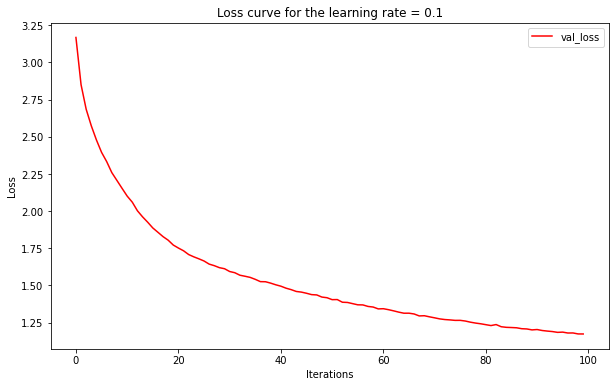

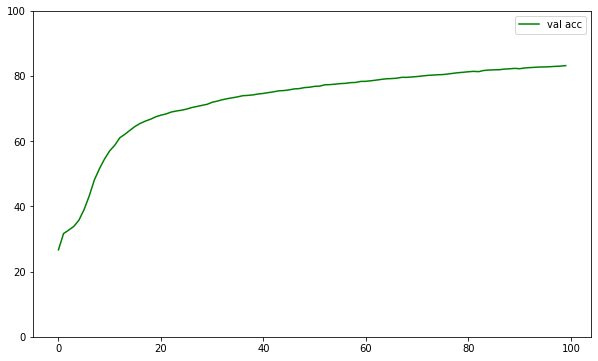

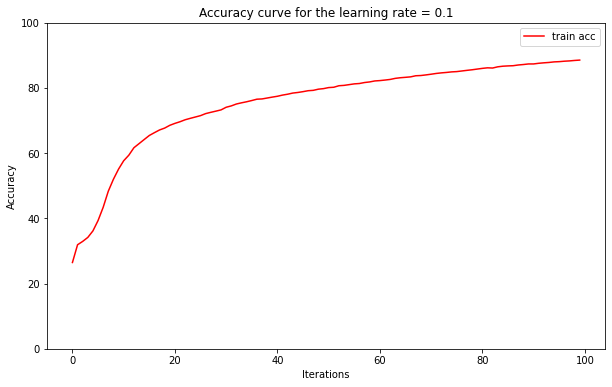

In [31]:
import warnings
warnings.filterwarnings("ignore")
fp = open('results_bal.txt', 'a')

nn_architecture = [
  {"layer_size": 900, "activation": "none"},
  {"layer_size": 300, "activation": "relu"},
  {"layer_size": 100, "activation": "relu"},
  {"layer_size": 10, "activation": "sigmoid"}
]

params = model(train_features, y_train, nn_architecture, exp_name='Exp1', initialization='range_initialization', lr=0.1, num_iterations=100)


accuracy(test_features, params, y_test, nn_architecture)

AL, _ = model_forward(test_features, params, nn_architecture)

from statistics import print_statistics

stats = print_statistics(AL, y_test)

fp.write("Experiment: Multi Layer Perceptron. range initialisatioin, 300 iterations\n\n")
fp.write(stats)
fp.close()